# Tutorial
The basic steps of ikarus are similar to the [sklearn workflow](https://scikit-learn.org/stable/getting_started.html#fitting-and-predicting-estimator-basics):

0. load data sets
1. init model
2. fit model
3. predict

In [1]:
import anndata
import pandas as pd
from pathlib import Path
from ikarus import classifier, utils

## load data sets
Laughney lung cancer and Lee colorectal cancer are used for training.<br>
Tirosh head & neck cancer is used for testing.<br>
Annotated data matrices are used here (see [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) for further information.)


In [2]:
paths = [
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/laughney20_lung/"),
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/lee20_crc/"),
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/tirosh17_headneck/")
]
names = [
    "laughney",
    "lee",
    "tirosh"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

In [3]:
adatas["lee"].obs.head(2)

,raw,major,major_hallmark_corrected,tier_0,tier_1,tier_2,tier_3,tier_4,tier_5,tier_0_hallmark_corrected
0,CMS2,Tumor,Tumor,Tumor,Epithelial,nan,nan,nan,nan,Tumor
1,CMS2,Tumor,Tumor,Tumor,Epithelial,nan,nan,nan,nan,Tumor


In [4]:
adatas["lee"].var.head(2)

,gene_symbol
A1BG,A1BG
A1BG-AS1,A1BG-AS1


In [5]:
adatas["lee"].to_df().head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2171C21.3,bP-2189O9.3,hsa-mir-1253
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.233330,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.465363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.259511,0.908856,0.259511,0.0,0.0,0.0,0.0,0.0


## signatures
Here we just define the path of our gene signatures of choice.<br>
(find more information on how the gene lists are created [below](#create-gene-lists))

Note: It is important that the name (see first column in the example) of the gene lists<br>
within the `signatures.gmt` file correspond to the cell type for which they are meaningful.<br>
`signatures.gmt` is tab-separated.

In [6]:
signatures_path = Path("out_tutorial/signatures.gmt")

In [7]:
pd.read_csv(signatures_path, sep="\t", header=None)

,0,1,2,3,4,5,6,7,8,9,...,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313
0,Normal,ikarus,RGS1,TSPAN8,CD8B,CLDN8,PIFO,C1ORF189,BCHE,ELFN1,...,RCN3,EDNRA,IFI27L2,RASL12,MYLK,DNAH9,BCAS1,GSTA3,FOXF2,ATP10B
1,Tumor,ikarus,RP11-277P12.10,RP13-895J2.6,BNC1,MAGEA6,ISX,MAGEA3,RP13-614K11.2,CDH7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## train model
Unlike the X and y input from the sklearn fitting, we are using here the AnnData object<br>
loaded above and the corresponding observation column (annotation). The input AnnData<br>
objects, names and target observation columns are each provided as lists. As one may want<br>
to use multiple input data sets.

(Note: Here this may take a while, as the used input data sets are quite large.<br>
Skip this cell in case you just want load the pretrained model.)

In [8]:
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out_tutorial")

train_adata_list = [adatas["laughney"], adatas["lee"]]
train_names_list = ["laughney", "lee"]
obs_columns_list = ["tier_0_hallmark_corrected", "tier_0_hallmark_corrected"]

model.fit(train_adata_list, train_names_list, obs_columns_list, save=True)

Alternatively just load the pretrained model.

In [9]:
model_path = Path("out_tutorial/core_model.joblib")
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out_tutorial")
model.load_core_model(model_path)

## make prediction
We provide the AnnData of an unknown data set, make predictions and save the results.

In [9]:
_ = model.predict(adatas['tirosh'], 'tirosh', save=True)

/home/jdohmen/.miniconda3/envs/ikarus/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


converged at iteration step: 9 with 0.0004 < 0.001


## plotting
Make plots to investigate the prediction results.

In [10]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax

In [11]:
_ = model.get_umap(adatas['tirosh'], 'tirosh', save=True)

... storing 'core_pred' as categorical
... storing 'final_pred' as categorical


In [12]:
path = Path("out_tutorial/tirosh")
results = pd.read_csv(path / "prediction.csv", index_col=0)
adata = anndata.read_h5ad(path / "adata_umap.h5ad")

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3363
       Tumor       1.00      1.00      1.00      2215

    accuracy                           1.00      5578
   macro avg       1.00      1.00      1.00      5578
weighted avg       1.00      1.00      1.00      5578



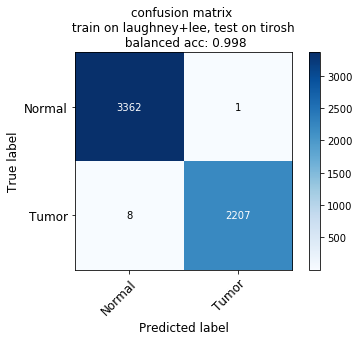

In [13]:
y = adata.obs.loc[:, 'tier_0']
y_pred_lr = results['final_pred']
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=['Normal', 'Tumor']))
_ = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=['Normal', 'Tumor'],
    title=f'confusion matrix \n train on laughney+lee, test on tirosh \n balanced acc: {acc:.3f}',
)

... storing 'tier_0_pred_correctness' as categorical


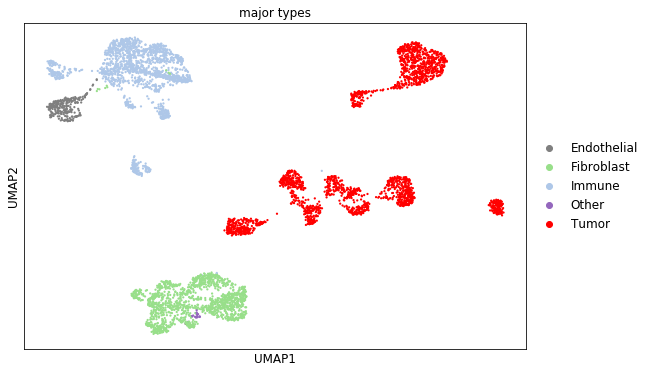

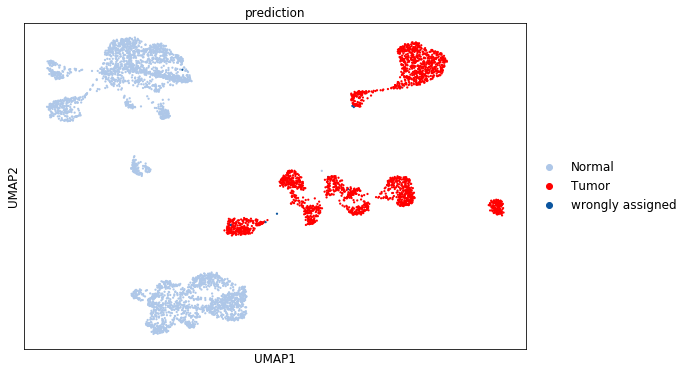

In [14]:
adata.obs.loc[:, 'tier_0_pred_correctness'] = 'wrongly assigned'
adata.obs.loc[
    adata.obs['tier_0'] == adata.obs['final_pred'],
    'tier_0_pred_correctness'
] = 'correctly assigned'
adata.obs.loc[:, 'tier_0_pred_wrong'] = pd.Categorical(
    adata.obs['tier_0'].copy(),
    categories=np.array(['Normal', 'Tumor', 'wrongly assigned']),
    ordered=True
)
adata.obs.loc[
    adata.obs['tier_0_pred_correctness'] == 'wrongly assigned',
    'tier_0_pred_wrong'
] = 'wrongly assigned'

plt.rcParams['figure.figsize'] = [9, 6]

colors = [
    ['major'],
    ['tier_0_pred_wrong']
    ]
titles = [
    ['major types'],
    ['prediction']
    ]
palettes = [
    ['#7f7f7f', '#98df8a', '#aec7e8', '#9467bd', '#ff0000'],
    ['#aec7e8', '#ff0000', '#0b559f'], 
]
for color, title, palette in zip(colors, titles, palettes):
    ax = sc.pl.umap(
        adata, ncols=1, size=20, 
        color=color,
        title=title,
        wspace=0.25,
        vmax='p99',
        legend_fontsize=12,
        palette=palette,
        show=False
    )
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.show()

## extra

### create gene lists

In [2]:
import upsetplot
from src.ikarus import gene_list

#### tumor

In [3]:
paths = [
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/laughney20_lung/"),
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/lee20_crc/")
]
names = [
    "laughney",
    "lee"
]
obs_names = [
    "major_hallmark_corrected",
    "major_hallmark_corrected"
]
label_upregs = [
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor"
]
label_downregs = [
    "Other",
    "Epithelial",
    "Immune",
    "Fibroblast",
    "Endothelial",
    "Pericyte"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

In [4]:
signatures = {}
for label_upreg, label_downreg in zip(label_upregs, label_downregs):
    DE_dfs_list = []
    for name, obs_name in zip(names, obs_names):
        DE_dfs_list.append(
            gene_list.select_genes(
                adatas[name], 
                obs_name,
                label_upreg, 
                label_downreg
            )
        )
    # If either label_upreg or label_downreg is not available in the provided data set
    # 'select_genes' returns None 
    # before continuing we have to remove all the Nones from the DE dataframe list
    DE_dfs_list = [d for d in DE_dfs_list if d is not None]
    signatures[f"{label_upreg}_vs_{label_downreg}"], _ = gene_list.integrate(
        DE_dfs_list, 
        integration_fun=utils.intersection_fun,
        top_x=300
    )

Either Tumor or Fibroblast is not available in given obs_name. None is returned.
Either Tumor or Endothelial is not available in given obs_name. None is returned.
Either Tumor or Pericyte is not available in given obs_name. None is returned.


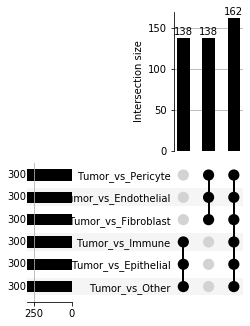

In [5]:
contents = upsetplot.from_contents(signatures)
_ = upsetplot.plot(contents, show_counts='%d')

In [6]:
# get the intersection of all the different gene lists
tumor_genes = contents.loc[(True, True, True, True, True, True)].values.ravel().tolist()

<ipython-input-6-17d175b8ab98>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  tumor_genes = contents.loc[(True, True, True, True, True, True)].values.ravel().tolist()


#### normal

In [7]:
paths = [
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/laughney20_lung/"),
    Path("/data/local/jdohmen/ikarus/data/sc_cancer/lee20_crc/")
]
names = [
    "laughney",
    "lee"
]
obs_names = [
    "major_hallmark_corrected",
    "major_hallmark_corrected"
]
label_downregs = [
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor",
    "Tumor"
]
label_upregs = [
    "Other",
    "Epithelial",
    "Immune",
    "Fibroblast",
    "Endothelial",
    "Pericyte"
]
adatas = {}
for path, name in zip(paths, names):
    adatas[name] = anndata.read_h5ad(path / "adata.h5ad")

In [8]:
signatures = {}
for label_upreg, label_downreg in zip(label_upregs, label_downregs):
    DE_dfs_list = []
    for name, obs_name in zip(names, obs_names):
        DE_dfs_list.append(
            gene_list.select_genes(
                adatas[name], 
                obs_name,
                label_upreg, 
                label_downreg
            )
        )
    # If either label_upreg or label_downreg is not available in the provided data set
    # 'select_genes' returns None 
    # before continuing we have to remove all the Nones from the DE dataframe list
    DE_dfs_list = [d for d in DE_dfs_list if d is not None]
    signatures[f"{label_upreg}_vs_{label_downreg}"], _ = gene_list.integrate(
        DE_dfs_list, 
        integration_fun=utils.intersection_fun,
        top_x=300
    )

Either Fibroblast or Tumor is not available in given obs_name. None is returned.
Either Endothelial or Tumor is not available in given obs_name. None is returned.
Either Pericyte or Tumor is not available in given obs_name. None is returned.


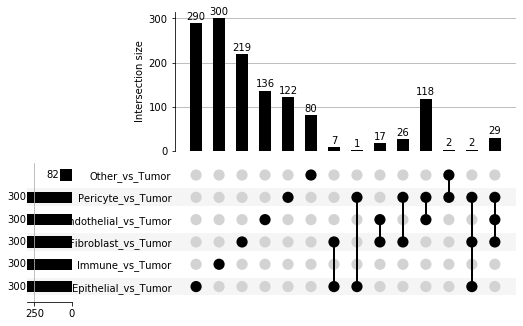

In [9]:
contents = upsetplot.from_contents(signatures)
_ = upsetplot.plot(contents, show_counts='%d')

In [10]:
# get unique genes 
normal_genes = pd.concat(
    [pd.DataFrame(signatures[key]) for key in signatures.keys()],
    ignore_index=True
)
normal_genes = normal_genes[0].unique().tolist()

In [11]:
# remove genes which are overlapping with the tumor gene list
overlap = list(set(tumor_genes) & set(normal_genes))
normal_genes = list(set(normal_genes) - set(overlap))

In [12]:
# save signatures as .gmt file
gene_list.save_gmt([tumor_genes, normal_genes], ["Tumor", "Normal"], out_dir="out_tutorial")